# Railvision project: Fusion Count

*Sources:*
- dataset: https://www.kaggle.com/datasets/tthien/shanghaitech
- references:
  - https://paperswithcode.com/paper/fusioncount-efficient-crowd-counting-via
  - https://paperswithcode.com/sota/crowd-counting-on-shanghaitech-b
  - https://paperswithcode.com/sota/crowd-counting-on-shanghaitech-a

## Library

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat
import random
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [55]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Exploration

In [ ]:
# Import module kebutuhan upload file dan upload file kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bizzati","key":"325e856e3cc446faac98d2f5cde4f62d"}'}

In [ ]:
# Download dataset dari kaggle lalu di unzip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tthien/shanghaitech
!unzip shanghaitech.zip

In [ ]:
# Penggabungan Part A dan Part B
from glob import glob

# Part A
a_img_dir_train = '/content/ShanghaiTech/part_A/train_data/images'
a_img_dir_test  = '/content/ShanghaiTech/part_A/test_data/images'
a_gt_dir_train  = '/content/ShanghaiTech/part_A/train_data/ground-truth'
a_gt_dir_test   = '/content/ShanghaiTech/part_A/test_data/ground-truth'

# Part B
b_img_dir_train = '/content/ShanghaiTech/part_B/train_data/images'
b_img_dir_test  = '/content/ShanghaiTech/part_B/test_data/images'
b_gt_dir_train  = '/content/ShanghaiTech/part_B/train_data/ground-truth'
b_gt_dir_test   = '/content/ShanghaiTech/part_B/test_data/ground-truth'

# Kumpulkan semua gambar dan ground truth dari Part A & B
image_paths = sorted(
    glob(a_img_dir_train + '/*.jpg') +
    glob(a_img_dir_test  + '/*.jpg') +
    glob(b_img_dir_train + '/*.jpg') +
    glob(b_img_dir_test  + '/*.jpg')
)

gt_paths = sorted(
    glob(a_gt_dir_train + '/*.mat') +
    glob(a_gt_dir_test  + '/*.mat') +
    glob(b_gt_dir_train + '/*.mat') +
    glob(b_gt_dir_test  + '/*.mat')
)

print(f"Total gambar ditemukan: {len(image_paths)}")
print(f"Total ground truth ditemukan: {len(gt_paths)}")

Total gambar ditemukan: 1198
Total ground truth ditemukan: 1198


In [ ]:
# Memastikan gambar dan ground truth cocok
print(image_paths[0])
print(gt_paths[0])

/content/ShanghaiTech/part_A/test_data/images/IMG_1.jpg
/content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat


## Preprocessing

### Split Dataset

In [50]:
TEST_SIZE = 0.2
VAL_SIZE = 0.1
RANDOM_SEED = 42

# Split data test dan train
train_imgs, test_imgs, train_gts, test_gts = train_test_split(
    image_paths, gt_paths, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

# Split data val dari sisa train
train_imgs, val_imgs, train_gts, val_gts = train_test_split(
    train_imgs, train_gts, test_size=VAL_SIZE / (1 - TEST_SIZE), random_state=RANDOM_SEED
)

print(f"Train: {len(train_imgs)}")
print(f"Val  : {len(val_imgs)}")
print(f"Test : {len(test_imgs)}")

Train: 838
Val  : 120
Test : 240


### Load Sample

In [51]:
def load_sample(img_path, mat_path):
    # Membaca gambar asli
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Gambar tidak bisa dibaca: {img_path}")

    # Load koordinat dari file .mat
    mat = loadmat(mat_path)

    # Mengambil koordinat titik (x,y) dari struktur image_info
    try:
        points = mat['image_info'][0, 0][0, 0][0]  # Ambil lokasi titik
        points = points.astype(np.float32)
    except Exception as e:
        raise ValueError(f"Ground truth tidak valid untuk file: {mat_path}\n{e}")

    return img, points

### Density Map Generation

In [52]:
IMG_SIZE    = (256, 256)
SIGMA       = 15
BATCH_SIZE  = 8

# Membuat density map dari titik anotasi
def create_density_map(shape, points, sigma=SIGMA):
    h, w = shape[:2]
    density = np.zeros((h, w), dtype=np.float32)
    for x, y in points:
        if 0 <= int(y) < h and 0 <= int(x) < w:
            density[int(y), int(x)] = 1
    return gaussian_filter(density, sigma=sigma, mode='constant')

### Data Augmentation & Normalization

In [53]:
# Memproses gambar dan anotasi ke ukuran/model input
def preprocess(img, points, img_size=IMG_SIZE):
    h0, w0 = img.shape[:2]
    img_r = cv2.resize(img, img_size)
    sx, sy = img_size[1] / w0, img_size[0] / h0

    pts = points.copy()
    pts[:, 0] *= sx
    pts[:, 1] *= sy

    img_n = img_r.astype(np.float32) / 255.0

    density = create_density_map(img_size, pts)

    if random.random() < 0.5:
        img_n = cv2.flip(img_n, 1)
        density = cv2.flip(density, 1)

    return img_n, density[..., None]

### Batch Generator

In [56]:
# Generator data dalam batch
def data_generator(img_paths, gt_paths, batch_size=BATCH_SIZE, shuffle=True):
    idxs = list(range(len(img_paths)))
    while True:
        if shuffle:
            random.shuffle(idxs)
        for i in range(0, len(idxs), batch_size):
            batch = idxs[i:i+batch_size]
            X, Y = [], []
            for j in batch:
                try:
                    img, pts = load_sample(img_paths[j], gt_paths[j])
                    xi, yi   = preprocess(img, pts)
                    X.append(xi)
                    Y.append(yi)
                except Exception as e:
                    print(f"Gagal memproses:\n- Gambar: {img_paths[j]}\n- GT: {gt_paths[j]}\nError: {e}")
            if X and Y:
                yield np.stack(X, 0), np.stack(Y, 0)

In [57]:
# Inisialisasi generator untuk training dan validasi
train_gen = data_generator(train_imgs, train_gts, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = data_generator(val_imgs,   val_gts,   batch_size=BATCH_SIZE, shuffle=False)

### Visualisasi Sample

Shape X: (8, 256, 256, 3)
Shape Y: (8, 256, 256, 1)


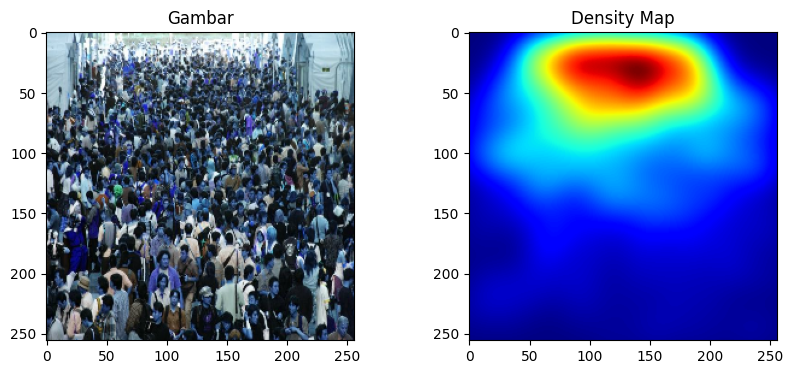

In [58]:
X_batch, Y_batch = next(train_gen)
print("Shape X:", X_batch.shape)
print("Shape Y:", Y_batch.shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_batch[0])
plt.title("Gambar")

plt.subplot(1, 2, 2)
plt.imshow(Y_batch[0].squeeze(), cmap='jet')
plt.title("Density Map")

plt.show()

## Model Development & Training: Fusion Count

### Model Development

In [59]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_norm_activation(x, filters, kernel_size=3, dilation_rate=1, activation='relu', name=None):
    x = layers.Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate,
                      use_bias=False, name=name and f"{name}_conv")(x)
    x = layers.BatchNormalization(name=name and f"{name}_bn")(x)
    if activation:
        x = layers.Activation(activation, name=name and f"{name}_{activation}")(x)
    return x

def build_fusion_count(input_shape=(256,256,3), batch_norm=True):
    inputs = layers.Input(shape=input_shape)
    # VGG16-BN backbone
    vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',
                                      input_tensor=inputs)
    # Extract conv block outputs
    # block1_conv2, block2_conv2, block3_conv3, block4_conv3, block5_conv3
    cb1 = vgg.get_layer('block1_conv2').output  # H/2
    cb2 = vgg.get_layer('block2_conv2').output  # H/4
    cb3 = vgg.get_layer('block3_conv3').output  # H/8
    cb4 = vgg.get_layer('block4_conv3').output  # H/16
    cb5 = vgg.get_layer('block5_conv3').output  # H/32

    # Channel reducers (dilation=2)
    r5 = conv_norm_activation(cb5, 256, dilation_rate=2, name='reducer5')
    up4 = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(r5)
    f4 = layers.Add()([up4, conv_norm_activation(cb4, 256, name='reduce_cb4')])
    r4 = conv_norm_activation(f4, 128, dilation_rate=2, name='reducer4')

    up3 = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(r4)
    f3 = layers.Add()([up3, conv_norm_activation(cb3, 128, name='reduce_cb3')])
    r3 = conv_norm_activation(f3, 64, dilation_rate=2, name='reducer3')

    up2 = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(r3)
    f2 = layers.Add()([up2, conv_norm_activation(cb2, 64, name='reduce_cb2')])
    r2 = conv_norm_activation(f2, 32, dilation_rate=2, name='reducer2')

    up1 = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(r2)
    f1 = layers.Add()([up1, conv_norm_activation(cb1, 32, name='reduce_cb1')])
    r1 = conv_norm_activation(f1, 16, dilation_rate=2, name='reducer1')

    density = layers.Conv2D(1, 1, padding='same', activation='relu', name='density_map')(r1)

    model = Model(inputs, density, name='FusionCountVGG')
    return model

model = build_fusion_count(input_shape=(256, 256, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)
model.summary()

Model: "FusionCountVGG"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer_4[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 17,856,657 (68.12 MB)

 Trainable params: 17,854,705 (68.11 MB)

 Non-trainable params: 1,952 (7.62 KB)

### Model Training

In [60]:
# Menghitung jumlah langkah per epoch berdasarkan ukuran dataset dan batch size
steps_per_epoch = len(train_imgs) // BATCH_SIZE
validation_steps = len(val_imgs) // BATCH_SIZE

# Callback jika val_loss tidak berubah
earlystop = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)

# Training model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[earlystop, reduce_lr],
    verbose=1
)

Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 428ms/step - loss: 0.0712 - mae: 0.1132 - val_loss: 0.0075 - val_mae: 0.0226 - learning_rate: 1.0000e-04
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 40s 387ms/step - loss: 0.0020 - mae: 0.0135 - val_loss: 0.0015 - val_mae: 0.0103 - learning_rate: 1.0000e-04
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 303ms/step - loss: 6.6394e-04 - mae: 0.0075 - val_loss: 3.9622e-04 - val_mae: 0.0056 - learning_rate: 1.0000e-04
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 32s 306ms/step - loss: 3.4132e-04 - mae: 0.0056 - val_loss: 2.3246e-04 - val_mae: 0.0047 - learning_rate: 1.0000e-04
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 302ms/step - loss: 2.6097e-04 - mae: 0.0052 - val_loss: 1.5574e-04 - val_mae: 0.0042 - learning_rate: 1.0000e-04
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 32s 305ms/step - loss: 1.9536e-04 - mae: 0.0046 - val_loss: 1.2889e-04 - val_mae: 0.0039 - learning_rate: 1.0000e-04
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 301ms/step - loss: 1.7054e-04 

## Evaluation

In [61]:
# Mengevaluasi model berdasarkan counting error
y_true_counts = []
y_pred_counts = []

for i in range(validation_steps):
    batch_x, batch_y = next(val_gen)
    y_pred = model.predict(batch_x)

    for true_map, pred_map in zip(batch_y, y_pred):
        y_true_counts.append(np.sum(true_map))
        y_pred_counts.append(np.sum(pred_map))

# Menghitung metrik evaluasi berdasarkan jumlah
mae = mean_absolute_error(y_true_counts, y_pred_counts)
mse = mean_squared_error(y_true_counts, y_pred_counts)

print(f"MAE (Count): {mae:.2f}")
print(f"MSE (Count): {mse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
MAE (Count): 210.75
MSE (Count): 134035.75


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


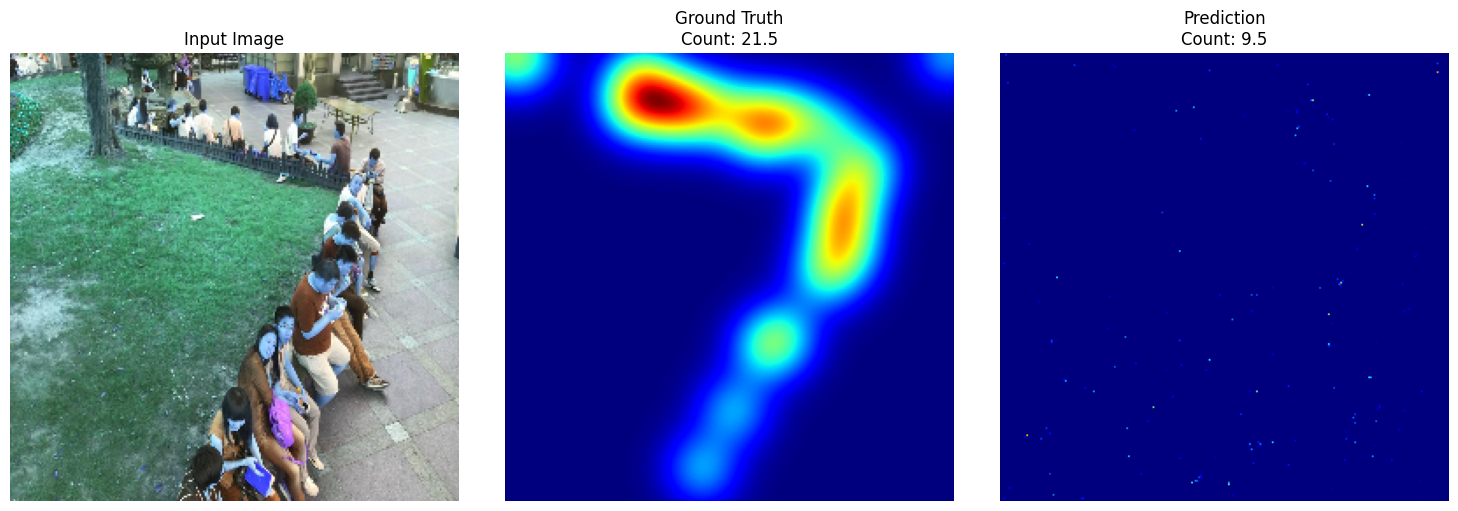

In [83]:
# Visualisasi satu sample dari validation set
sample_x, sample_y = next(iter(val_gen))
pred_y = model.predict(sample_x)

i = 0

plt.figure(figsize=(15, 5))

# Menampilkan gambar asli
plt.subplot(1, 3, 1)
img_show = (sample_x[i] * 255).astype(np.uint8)
plt.imshow(img_show)
plt.title("Input Image")
plt.axis('off')

# Menampilkan ground truth density map
plt.subplot(1, 3, 2)
plt.imshow(sample_y[i].squeeze(), cmap='jet')
plt.title(f"Ground Truth\nCount: {np.sum(sample_y[i]):.1f}")
plt.axis('off')

# Menampilkan prediksi density map
plt.subplot(1, 3, 3)
plt.imshow(pred_y[i].squeeze(), cmap='jet')
plt.title(f"Prediction\nCount: {np.sum(pred_y[i]):.1f}")
plt.axis('off')

plt.tight_layout()
plt.show()

## Menyimpan Model

In [97]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [100]:
import os
import tensorflow as tf
import tensorflowjs as tfjs
import numpy as np

os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite',      exist_ok=True)
os.makedirs('tfjs_model',  exist_ok=True)

model.save("fusion_model.h5")
model.export("saved_model")

# Convert & save ke TFLite
converter   = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TFLite model disimpan di 'tflite/model.tflite'")

# Convert & save ke TFJS
tfjs.converters.convert_tf_saved_model('saved_model', 'tfjs_model')
print("TFJS model disimpan di 'tfjs_model/' (terdiri dari model.json + *.bin)")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_220')
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  133053423450064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133053423449296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133053423450640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133053423440464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133053423445264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133053423444688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133053423443152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133053423442000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133053423440848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133053423442768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13305

In [101]:
from google.colab import files
import shutil

# Zip each model format folder
shutil.make_archive('saved_model', 'zip', 'saved_model')
shutil.make_archive('tflite', 'zip', 'tflite')
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

# Download the zip files to your local computer
files.download('saved_model.zip')
files.download('tflite.zip')
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Inference

In [94]:
img_path = list(uploaded.keys())[0]

# Preprocess gambar eksternal
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, IMG_SIZE)

img_norm = img_resized.astype(np.float32) / 255.0
input_tensor = np.expand_dims(img_norm, axis=0)

# Prediksi density map
pred_density = model.predict(input_tensor)[0].squeeze()
pred_count = np.sum(pred_density)

# Mengklasifikasi berdasarkan jumlah prediksi
def classify_density(count):
    if count < 50:
        return "Tidak ramai"
    elif count < 50:
        return "Ramai"
    else:
        return "Sangat ramai"

density_class = classify_density(pred_count)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


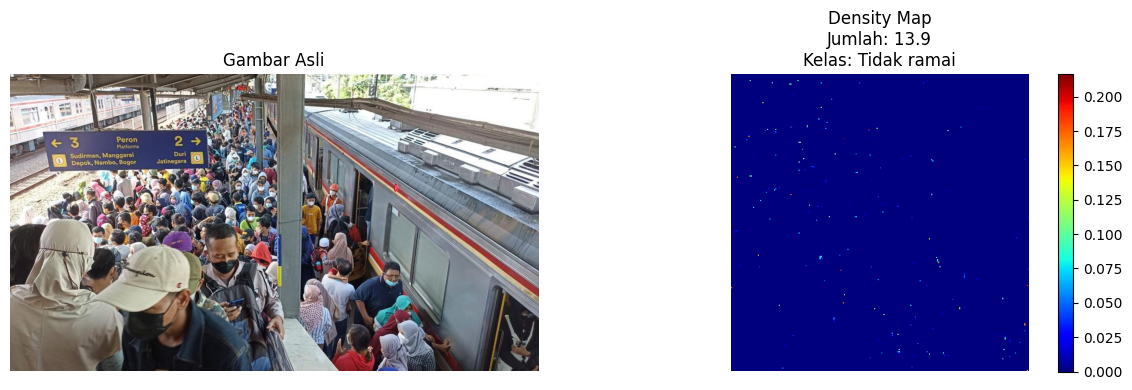

In [95]:
# Memvisualisasi hasil inferensi
plt.figure(figsize=(12, 4))

# Gambar asli
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Gambar Asli")
plt.axis('off')

# Density map serta prediksi jumlah dan kelas
plt.subplot(1, 2, 2)
plt.imshow(pred_density, cmap='jet')
plt.title(f"Density Map\nJumlah: {pred_count:.1f}\nKelas: {density_class}")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

In [93]:
# Mengupload gambar eksternal untuk inferensi
from google.colab import files
uploaded = files.upload()

Saving Inference tanah abang.jpeg to Inference tanah abang (1).jpeg
